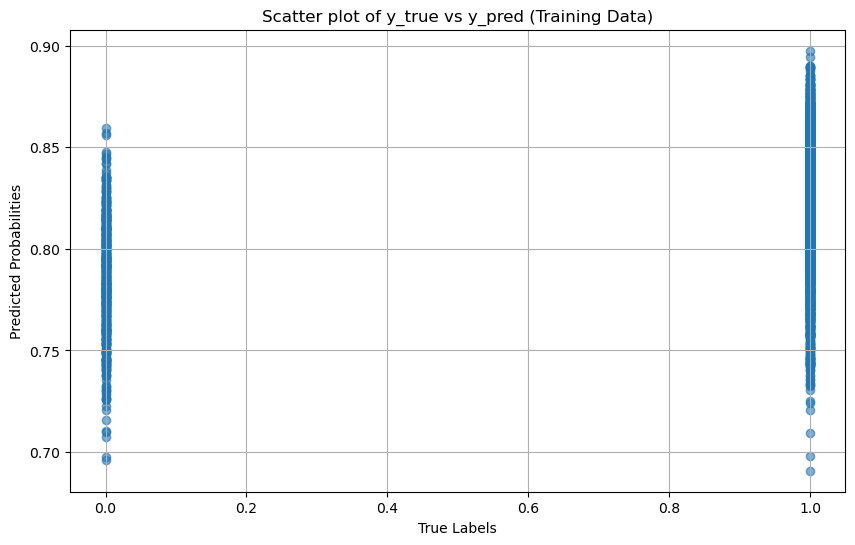

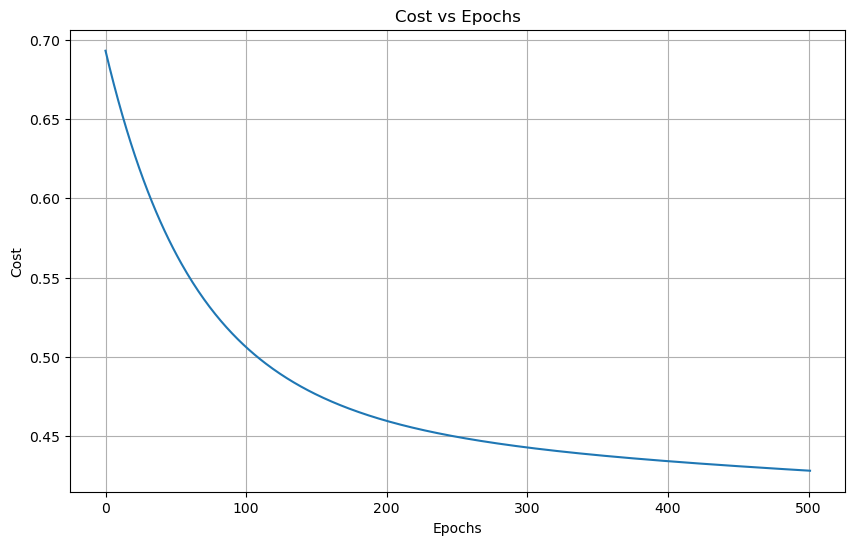

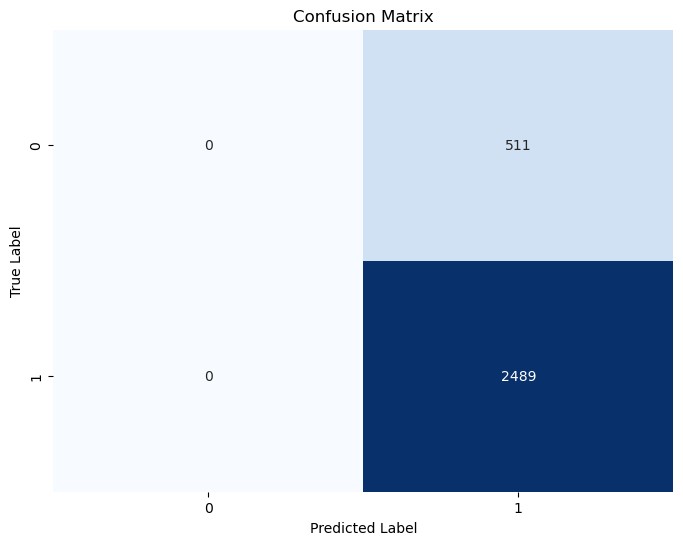

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Logistic Regression implementation
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, early_stopping_rounds=None, tol=1e-4):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None
        self.cost_history = []
        self.early_stopping_rounds = early_stopping_rounds
        self.tol = tol

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def compute_cost(self, y_true, y_pred):
        m = y_true.shape[0]
        return -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0

        for i in range(self.max_iter):
            model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(model)

            dw = 1/m * np.dot(X.T, (y_pred - y))
            db = 1/m * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            cost = self.compute_cost(y, y_pred)
            self.cost_history.append(cost)

            if self.early_stopping_rounds:
                if i > self.early_stopping_rounds:
                    if abs(self.cost_history[-1] - self.cost_history[-2]) < self.tol:
                        break

    def predict_proba(self, X):
        model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(model)
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# Load the training and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Prepare the data
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.values

# Initialize and train the logistic regression model
log_reg = LogisticRegression(learning_rate=0.01, max_iter=1000, early_stopping_rounds=500, tol=1e-4)
log_reg.fit(X_train, y_train)

# Predict on training data and plot y_true vs y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_train, log_reg.predict_proba(X_train), alpha=0.6)
plt.title('Scatter plot of y_true vs y_pred (Training Data)')
plt.xlabel('True Labels')
plt.ylabel('Predicted Probabilities')
plt.grid(True)
plt.show()

# Plot of cost vs epochs
plt.figure(figsize=(10, 6))
plt.plot(log_reg.cost_history)
plt.title('Cost vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

# Generate and plot confusion matrix
y_pred_train = log_reg.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict on test data and save to CSV
y_pred_test = log_reg.predict_proba(X_test)
np.savetxt("y_pred_new.csv", y_pred_test, delimiter=",")


data shape = (3000, 10)
training data shape = (2100, 10)
validation data shape = (600, 10)
test data shape = (300, 10)
Shape of X: (2100, 10)
Shape of y: (2100,)
Final weights: [-0.06065192  4.4870718  -1.62290987  0.4283464   0.01226318  0.25520539
  0.0614899   0.17873492  0.46806863  0.13099253]
Final cost: 0.2292312224437576


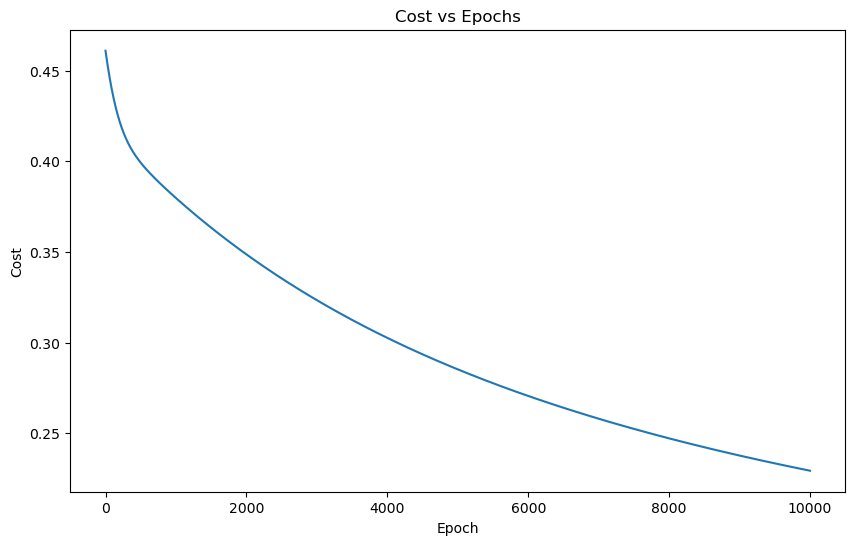

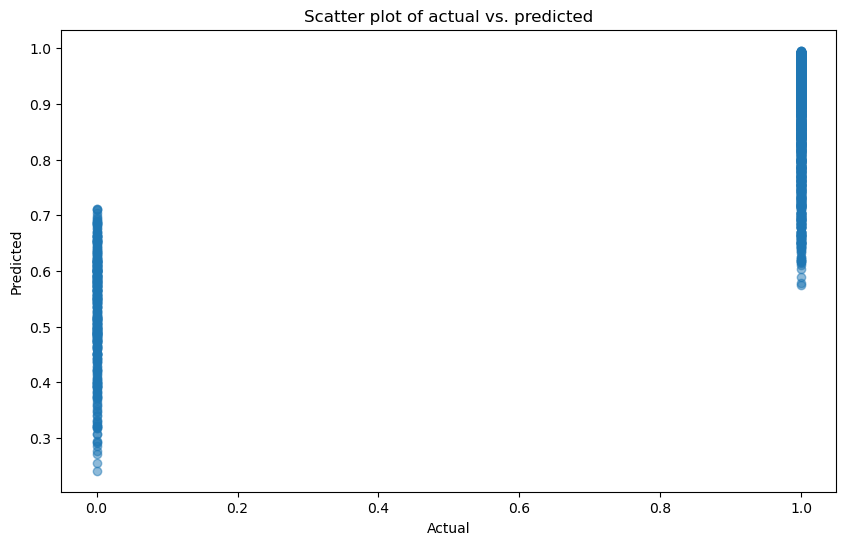

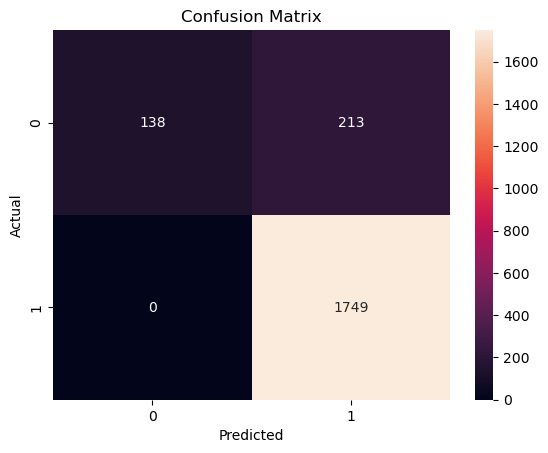

In [1]:
#!/usr/bin/env python
# coding: utf-8

# ## Logistic Regression
# 
# ### Exam 1b
# 
# 1. Read train.csv and test.csv

# In[6]:


import pandas as pd
import numpy as np
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(f'data shape = {train_df.shape}')


# 2. Split into 70% train, 20% validation and 10% test

# In[7]:


from sklearn.model_selection import train_test_split

# Split into 70% train and 30% temporary
train_data, temp_data = train_test_split(train_df, test_size=0.3, random_state=42)

# Split the temporary set into 20% validation and 10% test
validation_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

print(f'training data shape = {train_data.shape}')
print(f'validation data shape = {validation_data.shape}')
print(f'test data shape = {test_data.shape}')


# 3. Pre-setup

# In[8]:


# Initialize weights randomly for 9 features, the bias term will be included as w1
W = np.random.rand(10)

# Set hyperparameters
alpha = 0.01  # Learning rate
epsilon = 0.00001  # Convergence criterion
epochs = 10000  # Number of iterations over the entire dataset


# In[9]:


# Separate features and target
features = train_data.iloc[:, :-1]  # all rows, all columns except the last one
target = train_data.iloc[:, -1]  # all rows, just the last column

# Number of samples
M = features.shape[0]

# Add a column of ones to the feature matrix to account for the bias term
X = np.hstack((np.ones((M, 1)), features.values))

# Target vector
y = target.values

# Verify the shapes of X and y
print("Shape of X:", X.shape)  # Should be (M, 10) including the bias term
print("Shape of y:", y.shape)  # Should be (M,)


# In[10]:


# Sigmoid function definition
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function definition for logistic regression
def compute_cost(X, y, W):
    m = y.shape[0]
    h = sigmoid(np.dot(X, W))
    cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

# Gradient descent function definition
def gradient_descent(X, y, W, alpha, epsilon, epochs):
    m = y.shape[0]
    cost_history = []  # Keep track of the cost every epoch for plotting/verification purposes

    for epoch in range(epochs):
        # Step 1: Calculate the hypothesis h using matrix multiplication
        h = sigmoid(np.dot(X, W))
        
        # Step 2: Calculate the error
        error = h - y
        
        # Step 3: Calculate the gradient using matrix multiplication
        gradient = np.dot(X.T, error) / m
        
        # Step 4: Update the weights using matrix subtraction and scalar multiplication
        W_old = W.copy()
        W = W - alpha * gradient
        
        # Optional: Save the cost to the history for later
        cost = compute_cost(X, y, W)
        cost_history.append(cost)
        
        # Step 5: Check for convergence (if the change in cost function is less than epsilon)
        if np.all(np.abs(W_old - W) < epsilon):
            print(f'Convergence reached at epoch: {epoch}')
            break
    
    return W, cost_history

# Perform gradient descent
W, cost_history = gradient_descent(X, y, W, alpha, epsilon, epochs)

# Output the final weights and cost
print("Final weights:", W)
print("Final cost:", cost_history[-1])


# In[11]:


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming that 'W' are the weights after performing gradient descent,
# 'X' is the feature matrix, and 'y' is the true labels

# Calculate predictions
h = sigmoid(np.dot(X, W))

# Threshold the predictions to get binary class predictions
y_pred = h >= 0.5

# Plot of cost vs epochs
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Cost vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

# Scatter plot of y_true vs y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y, h, alpha=0.5)
plt.title('Scatter plot of actual vs. predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# In[ ]:




